In [17]:
# ================================ Importy i ustawienia ================================================================================
# !pip install optuna
# !pip install group_lasso
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import xgboost as xgb
import shap
import kagglehub

from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from group_lasso import GroupLasso


pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.width', 1000)
plt.rcParams.update({'font.size': 8})

In [18]:
# ================================ Zaimporotwanie stałych globalnych i funkcji ========================================================

# Import stałych globalnych
from resources.config import *

# Import funkcji z plików zewnętrznych
from defs.clean_data import clean_data
from defs.create_lags import create_lags
from defs.optuna_objective import objective
from defs.statistics import statistics

In [19]:
# ================================ Dane źródłowe z Kaggle ================================

# Zestaw danych Kaggle World-Stock-Prices-Dataset.csv
filename = 'World-Stock-Prices-Dataset.csv'
path = kagglehub.dataset_download('nelgiriyewithana/world-stock-prices-daily-updating')
fullpath = os.path.join(path, filename)
data = pd.read_csv(fullpath)


# ================================ Wstępna analiza danych ===================================================================
data['Date'] = pd.to_datetime(data['Date'], utc=True)   # Zmiana formatu daty aby móc analizować szeregi czasowe
newest_date = data.iloc[1]['Date'].date()               # Najnowsza data w pobranym zbiorze danych, tylko data bez godziny

print('\n~~~~~~~~~~~~~~~~~~~~ WITAJ W ANALIZIE DANYCH WORLD STOCK PRICES DATASET! ~~~~~~~~~~~~~~~~~~~~')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Najnowsze dane z dnia: ', newest_date, ' ~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

# Połączenie niektórych kategorii w jedną z uwagi na podobieństwo i małą liczność spółek w danych grupach
data['Industry_Tag'] = data['Industry_Tag'].replace('financial services', 'finance')
data['Industry_Tag'] = data['Industry_Tag'].replace('food & beverage', 'food')
data['Industry_Tag'] = data['Industry_Tag'].replace('music', 'entertainment')

industries = data['Industry_Tag'].unique()

print('\n Sektory biorące udział w analizie: \n')

# Utworzenie tabelki z unikalnymi spółkami per sektor
data_industries = data.groupby('Industry_Tag')['Brand_Name']\
    .apply(lambda x: sorted(list(set(x))))\
    .reset_index()

# Zmiana nazwy kolumn dla czytelności
data_industries.columns = ['Industry_Tag', 'Brand_Names']

print(data_industries)


# Wybór sektora
while True:
    sector_Y = input('Napisz nazwę sektora do analizy: ')
    if sector_Y in industries:
        print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Sektor analizowany: ', sector_Y, '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        break
    else:
        print('!!! Niepoprawne słowo !!! Spróbuj ponownie.')


# Wyczyszczenie danych duplikujących się:
data = data.drop_duplicates(subset=['Date', 'Brand_Name'])
statistics(data, 'dane źródłowe z csv')


~~~~~~~~~~~~~~~~~~~~ WITAJ W ANALIZIE DANYCH WORLD STOCK PRICES DATASET! ~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Najnowsze dane z dnia:  2025-01-24  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~

 Sektory biorące udział w analizie: 

      Industry_Tag                                                                                          Brand_Names
0          apparel                                                      [adidas, american eagle outfitters, nike, puma]
1       automotive                                                           [bmw group, honda, porsche, tesla, toyota]
2         aviation                                                                [delta air lines, southwest airlines]
3   consumer goods                                                      [colgate palmolive, procter & gamble, unilever]
4   cryptocurrency                                                                                           [coinbase]
5       e-commerce                                  

In [20]:
print('\n~~~~~~~~~~~~~~~~~~~~ PRZYGOTOWANIE DANYCH PER SEKTOR ~~~~~~~~~~~~~~~~~~~~')

# Obliczenie średniej ważonej ceny zamknięcia dla każdego sektora (Industry_Tag)
data_industry = (
    data.assign(weighted_close=data['Close'] * data['Volume'])        # Dodanie kolumny z wagą
    .groupby(['Date', 'Industry_Tag'])[['weighted_close', 'Volume']]  # Grupowanie
    .sum()                                                            # Sumowanie wag i wolumenów w grupach
    .eval('weighted_close / Volume')                                  # Obliczenie średniej ważonej
    .unstack()                                                        # Przekształcenie grup w kolumny dla każdego 'Industry_Tag'
)

# Przygotowanie danych tygodniowych
days_resampling = {
    0: 'W-MON',  # Poniedziałek
    1: 'W-TUE',  # Wtorek
    2: 'W-WED',  # Środa
    3: 'W-THU',  # Czwartek
    4: 'W-FRI',  # Piątek
    5: 'W-SAT',  # Sobota
    6: 'W-SUN'   # Niedziela
}

# Reguła resamplingu w zależności od ostatniego notowania
weekday = newest_date.weekday()
rule = days_resampling[weekday]
data_industry_weekly = data_industry.resample(rule).mean()

data_industry_weekly = data_industry_weekly.reset_index()

print('\nŚrednia ważona cen zamknięcia dla każdego sektora (tygodniowo) - najnowsze dane:')
print(data_industry_weekly.tail())

# Usunięcie sektorów z niewystarczającą ilością danych
clean_data(data_industry_weekly, TRAIN_SIZE + VAL_SIZE + TEST_SIZE)

# Oblicz i wyświetl statystyki dla danych tygodniowych
statistics(data_industry_weekly, 'tygodniowe indeksy sektorowe')

if sector_Y not in data_industry_weekly.columns:
    print('\nUwaga! Sektor wybrany do analizy nie posiada wystarczającej ilości danych. Wybierz inny sektor!')



~~~~~~~~~~~~~~~~~~~~ PRZYGOTOWANIE DANYCH PER SEKTOR ~~~~~~~~~~~~~~~~~~~~

Średnia ważona cen zamknięcia dla każdego sektora (tygodniowo) - najnowsze dane:
Industry_Tag                      Date    apparel  automotive   aviation  consumer goods  cryptocurrency  e-commerce  entertainment     finance  fitness       food   footwear     gaming  healthcare  hospitality   logistics  luxury goods  manufacturing      retail  social media  technology
1303         2024-12-27 00:00:00+00:00  58.417885  420.431168  51.528039      122.781123      271.972496  212.422982     423.621624  258.301968   9.5725  91.603261  46.391688  47.322522  145.437504   181.071504  274.967499    132.220001     130.174995  235.161525     29.712500  164.086584
1304         2025-01-03 00:00:00+00:00  57.938331  392.423969  49.036089      120.640217      257.929996  207.852140     372.190254  244.966969   8.8900  93.329109  44.992860  52.461944  144.042500   189.643005  277.642494    129.437504     129.447498  269.649912

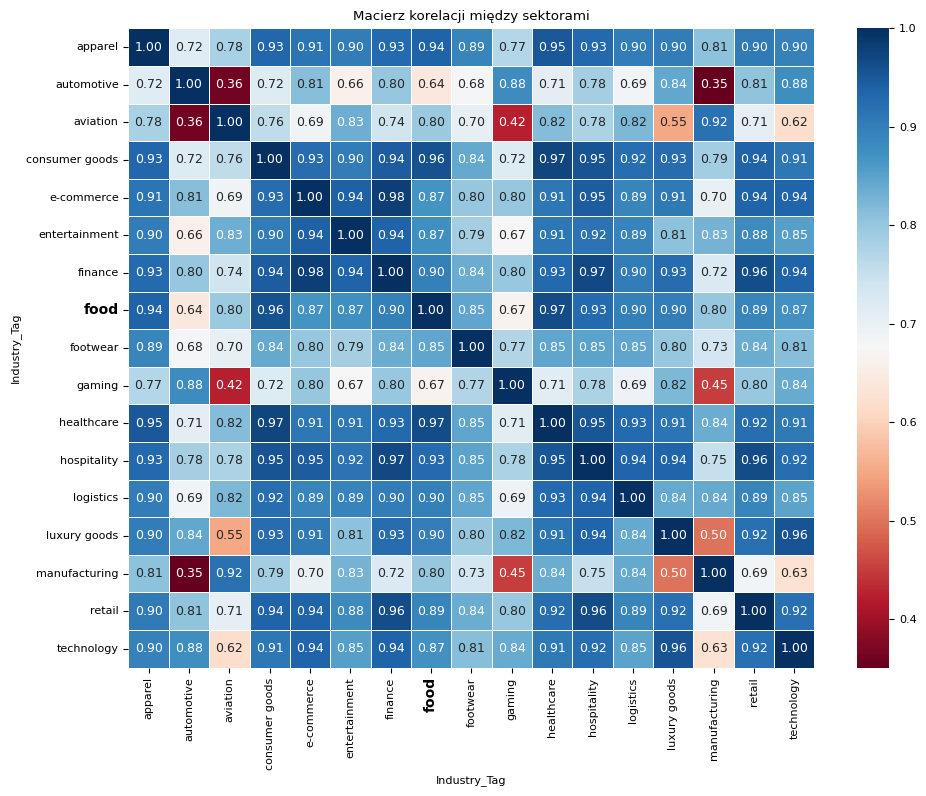

In [21]:
# ================================= Analiza korelacji =================================

# Korelacja
numeric_data = data_industry_weekly.select_dtypes(include='number')
correlation_matrix = numeric_data.corr()

plt.figure(figsize=(10, 8))
macierz = sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', fmt='.2f', linewidths=0.5, annot_kws={'size': 9})

# Pogrubienie wybranej nazwy na osi X
for label in macierz.get_xticklabels():
    if label.get_text() == sector_Y:
        label.set_weight('bold')
        label.set_fontsize(10)

# Pogrubienie wybranej nazwy na osi Y
for label in macierz.get_yticklabels():
    if label.get_text() == sector_Y:
        label.set_weight('bold')
        label.set_fontsize(10)

plt.title(f'Macierz korelacji między sektorami')
plt.tight_layout()
plt.show()

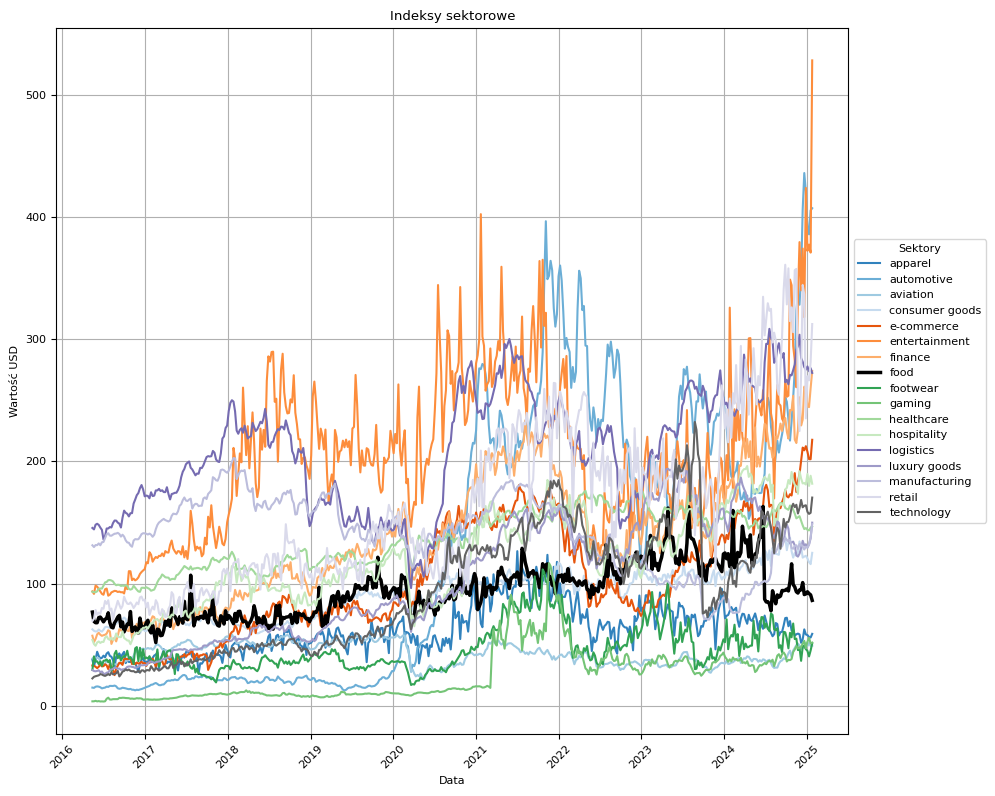

In [22]:
# ============================= Wykres liniowy =============================

# Wykres liniowy tylko dla wybranego okna czasowego (train+test)
data_industry_shortened = data_industry_weekly.tail(TRAIN_SIZE + TEST_SIZE + LAG_WEEKS)

plt.figure(figsize=(10, 8))
palette = sns.color_palette('tab20c', n_colors=len(data_industry_shortened.columns[1:]))

# Iterowanie po zmiennych i ich wykres
for i, column in enumerate(data_industry_shortened.columns[1:]):  # iterujemy po indeksie oraz po nazwie kolumny
    if column == sector_Y:
        # Wyróżnienie koloru i grubości dla wybranej zmiennej
        plt.plot(data_industry_shortened['Date'], data_industry_shortened[column], label=column, color='black', linewidth=2.5)
    else:
        plt.plot(data_industry_shortened['Date'], data_industry_shortened[column], label=column, color=palette[i])

# Dostosowanie wykresu
plt.title('Indeksy sektorowe')
plt.xlabel('Data')
plt.ylabel('Wartość USD')
plt.legend(title='Sektory', loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.xticks(rotation=45)

# Wyświetlanie wykresu
plt.tight_layout()
plt.show()



In [23]:
# =============================== Zmienne opóźnione ===============================================================================
print('\n~~~~~~~~~~~~~~~~~~~~ PRZYGOTOWANIE DANYCH OPÓŹNIONYCH (' + str(LAG_WEEKS) + ' weeks) ~~~~~~~~~~~~~~~~~~~~')

data_industry_filtered = data_industry_weekly.drop(columns='Date')  # usuwamy kolumnę z datą

# Utworzenie zmiennych opóźnionych (do szeregu czasowego żeby móc wykorzystać xgboost)
data_lagged = create_lags(data_industry_filtered, LAG_WEEKS, sector_Y)
data_lagged = data_lagged.dropna()

statistics(data_lagged, 'dane z indeksami sektorowymi i opóźnieniami')


# ============================= Przygotowanie zbioru do modelowania ================================================================

X = data_lagged.drop(columns=sector_Y)  # Wszystkie kolumny oprócz Y
y = data_lagged[sector_Y]               # Zmienna docelowa




~~~~~~~~~~~~~~~~~~~~ PRZYGOTOWANIE DANYCH OPÓŹNIONYCH (5 weeks) ~~~~~~~~~~~~~~~~~~~~

Statystyki dla danych:  dane z indeksami sektorowymi i opóźnieniami
                       food apparel_lag_1 apparel_lag_2 apparel_lag_3 apparel_lag_4 apparel_lag_5 automotive_lag_1 automotive_lag_2 automotive_lag_3 automotive_lag_4 automotive_lag_5 aviation_lag_1 aviation_lag_2 aviation_lag_3 aviation_lag_4 aviation_lag_5 consumer goods_lag_1 consumer goods_lag_2 consumer goods_lag_3 consumer goods_lag_4 consumer goods_lag_5 e-commerce_lag_1 e-commerce_lag_2 e-commerce_lag_3 e-commerce_lag_4 e-commerce_lag_5 entertainment_lag_1 entertainment_lag_2 entertainment_lag_3 entertainment_lag_4 entertainment_lag_5 finance_lag_1 finance_lag_2 finance_lag_3 finance_lag_4 finance_lag_5 food_lag_1 food_lag_2 food_lag_3 food_lag_4 food_lag_5 footwear_lag_1 footwear_lag_2 footwear_lag_3 footwear_lag_4 footwear_lag_5 gaming_lag_1 gaming_lag_2 gaming_lag_3 gaming_lag_4 gaming_lag_5 healthcare_lag_1 healthcare_lag_

In [24]:
# ============================= Group Lasso do wyboru zmiennych =================================================================
print('\n~~~~~~~~~~~~~~~~~~~~ GRUPOWANIE ZMIENNYCH (GROUP LASSO) ~~~~~~~~~~~~~~~~~~~~')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Tworzenie słownika grup i przypisywanie kolumn
grouped_X = {f'{group}_group': [col for col in X.columns if group in col] for group in industries}

# Wyświetlenie wyników
for group_name, cols in grouped_X.items():
    print(f'{group_name}: {cols}')

# Numerowanie grup
group_map = {group_name: i for i, group_name in enumerate(grouped_X.keys())}

# Lista grup dla każdej kolumny (konwersja do listy)
column_to_group = []
for group_name, columns in grouped_X.items():
    group_number = group_map[group_name]
    column_to_group.extend([group_number] * len(columns))

group_lasso = GroupLasso(
    groups=column_to_group,   # Lista numerów grup
    group_reg=0.1,            # Siła regularyzacji dla grup, jeśli dana grupa cech zostanie uznana za nieistotną, wszystkie cechy w tej grupie będą miały współczynniki równe 0, a żadna z nich nie znajdzie się w selected_features
    l1_reg=0.1,               # Siła regularyzacji L1, może wyzerować współczynniki pojedynczych cech w ramach grupy, nawet jeśli sama grupa jako całość jest zachowana
    scale_reg='none',         # Skalowanie kar w zależności od wielkości grupy (brak bo grupy są takie same wielkościowo)
    supress_warning=True,
    n_iter=5000
)

group_lasso.fit(X_scaled, y)

# Wybrane zmienne na podstawie współczynników
coefficients = group_lasso.coef_.ravel()  # Przekształcenie na wektor 1-wymiarowy
features_lasso = X.columns[coefficients != 0]

# Tworzenie DataFrame z nazwami cech i ich współczynnikami
coefficients_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients})

coefficients_df = coefficients_df[coefficients_df['Coefficient'] != 0]

print('\nWybrane cechy po analizie Group Lasso: \n', coefficients_df.sort_values(by='Feature', ascending=True))

X_po_lasso = X[features_lasso]  # Tylko zmienne wybrane w poprzednim kroku




~~~~~~~~~~~~~~~~~~~~ GRUPOWANIE ZMIENNYCH (GROUP LASSO) ~~~~~~~~~~~~~~~~~~~~
fitness_group: []
food_group: ['food_lag_1', 'food_lag_2', 'food_lag_3', 'food_lag_4', 'food_lag_5']
retail_group: ['retail_lag_1', 'retail_lag_2', 'retail_lag_3', 'retail_lag_4', 'retail_lag_5']
e-commerce_group: ['e-commerce_lag_1', 'e-commerce_lag_2', 'e-commerce_lag_3', 'e-commerce_lag_4', 'e-commerce_lag_5']
technology_group: ['technology_lag_1', 'technology_lag_2', 'technology_lag_3', 'technology_lag_4', 'technology_lag_5']
apparel_group: ['apparel_lag_1', 'apparel_lag_2', 'apparel_lag_3', 'apparel_lag_4', 'apparel_lag_5']
entertainment_group: ['entertainment_lag_1', 'entertainment_lag_2', 'entertainment_lag_3', 'entertainment_lag_4', 'entertainment_lag_5']
gaming_group: ['gaming_lag_1', 'gaming_lag_2', 'gaming_lag_3', 'gaming_lag_4', 'gaming_lag_5']
aviation_group: ['aviation_lag_1', 'aviation_lag_2', 'aviation_lag_3', 'aviation_lag_4', 'aviation_lag_5']
automotive_group: ['automotive_lag_1', 'automoti

In [25]:
#=============================== Podział na zbiór treningowy i testowy ===================================================================
#Ze względu na analizę szeregu czasowego nie możemy podzielić zbioru w sposób losowy
#Rozmiary TRAIN_SIZE i TEST_SIZE podano na początku skryptu

X_train = X_po_lasso[-(TRAIN_SIZE + TEST_SIZE):-TEST_SIZE]  # Ostatnie TRAIN_SIZE próbek przed testowymi
y_train = y[-(TRAIN_SIZE + TEST_SIZE):-TEST_SIZE]
X_test = X_po_lasso[-TEST_SIZE:]    #najnowsze próbki (TEST_SIZE)
y_test = y[-TEST_SIZE:]

print('\n~~~~~~~~~~~~~~~~~~~~ Zbiór treningowy i testowy po analize Group Lasso ~~~~~~~~~~~~~~~~~~~~')
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)




~~~~~~~~~~~~~~~~~~~~ Zbiór treningowy i testowy po analize Group Lasso ~~~~~~~~~~~~~~~~~~~~
X_train:  (400, 14)
y_train:  (400,)
X_test:  (50, 14)
y_test:  (50,)


In [26]:
# ================ Model XGBoost - do kolejnej selekcji zmiennych według feature importance  ===============================

model=xgb.XGBRegressor()
model.fit(X_train, y_train)

# Predykcje
y_pred = model.predict(X_test)

# Gain importance
gain_importance = model.get_booster().get_score(importance_type='gain')

# Tworzenie DataFrame na podstawie nazwy cech i ich Gain z gain_importance
importance_df = pd.DataFrame(list(gain_importance.items()), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Obliczenie skumulowanej ważności
importance_df['Cumulative_Importance'] = importance_df['Importance'].cumsum() / importance_df['Importance'].sum()

# Wybranie cech do 99% skumulowanej ważności (usunięcie zmiennych najmniej ważnych - szum)
selected_features = importance_df[importance_df['Cumulative_Importance'] <= 0.99]['Feature'].tolist()

print('\nWybrano cechy według Feature Importance: ', len(selected_features), selected_features)

X_final = X_po_lasso[selected_features]

print('\nZaktualizowany zbiór X:', X_final.shape)


Wybrano cechy według Feature Importance:  11 ['food_lag_1', 'healthcare_lag_2', 'food_lag_2', 'healthcare_lag_1', 'food_lag_5', 'food_lag_3', 'healthcare_lag_3', 'healthcare_lag_5', 'food_lag_4', 'healthcare_lag_4', 'apparel_lag_4']

Zaktualizowany zbiór X: (987, 11)


In [27]:
# ============================ Optuna do optymalizacji hiperparametrów ============================================================================
print('\n~~~~~~~~~~~~~~~~~~~~ Optymalizacja hiperparametrów modelu ~~~~~~~~~~~~~~~~~~~~')
study = optuna.create_study(direction='minimize')

study.optimize(lambda trial: objective(trial, X_final, y, TRAIN_SIZE, VAL_SIZE, TEST_SIZE), n_trials=ITERATIONS, timeout=3600, n_jobs=10)

# Najlepsze parametry
print('\nNajlepsze parametry: ', study.best_params)


[I 2025-01-28 00:14:48,027] A new study created in memory with name: no-name-7a4b83de-6926-45a5-ac4a-2b94e0b8a8c7



~~~~~~~~~~~~~~~~~~~~ Optymalizacja hiperparametrów modelu ~~~~~~~~~~~~~~~~~~~~


[I 2025-01-28 00:14:48,508] Trial 2 finished with value: 19.44941576186206 and parameters: {'learning_rate': 0.012509959296885628, 'reg_alpha': 4.950014466442812, 'reg_lambda': 4.214721446306185}. Best is trial 2 with value: 19.44941576186206.
[I 2025-01-28 00:14:48,556] Trial 6 finished with value: 18.21772027905939 and parameters: {'learning_rate': 0.01686416754354404, 'reg_alpha': 4.716345420562146, 'reg_lambda': 3.946522016489365}. Best is trial 6 with value: 18.21772027905939.
[I 2025-01-28 00:14:48,603] Trial 9 finished with value: 17.51584468728007 and parameters: {'learning_rate': 0.021854241611164227, 'reg_alpha': 1.6799372355751858, 'reg_lambda': 4.631093599420547}. Best is trial 9 with value: 17.51584468728007.
[I 2025-01-28 00:14:48,620] Trial 1 finished with value: 17.77563874814072 and parameters: {'learning_rate': 0.020100524869236757, 'reg_alpha': 0.9008586150927644, 'reg_lambda': 3.956859878993679}. Best is trial 9 with value: 17.51584468728007.
[I 2025-01-28 00:14:48,


Najlepsze parametry:  {'learning_rate': 0.0918449266545337, 'reg_alpha': 0.2155545805721797, 'reg_lambda': 1.0145331872761691}



~~~~~~~~~~~~~~~~~~~~ Zbiór treningowy i testowy do XGBoost (final model) ~~~~~~~~~~~~~~~~~~~~
X_train:  (400, 11)
y_train:  (400,)
X_test:  (50, 11)
y_test:  (50,)

RMSE modelu (trening): 0.9
MAPE modelu (trening): 0.71 %

RMSE modelu (okres testowy): 11.6
MAPE modelu (okres testowy): 7.97 %


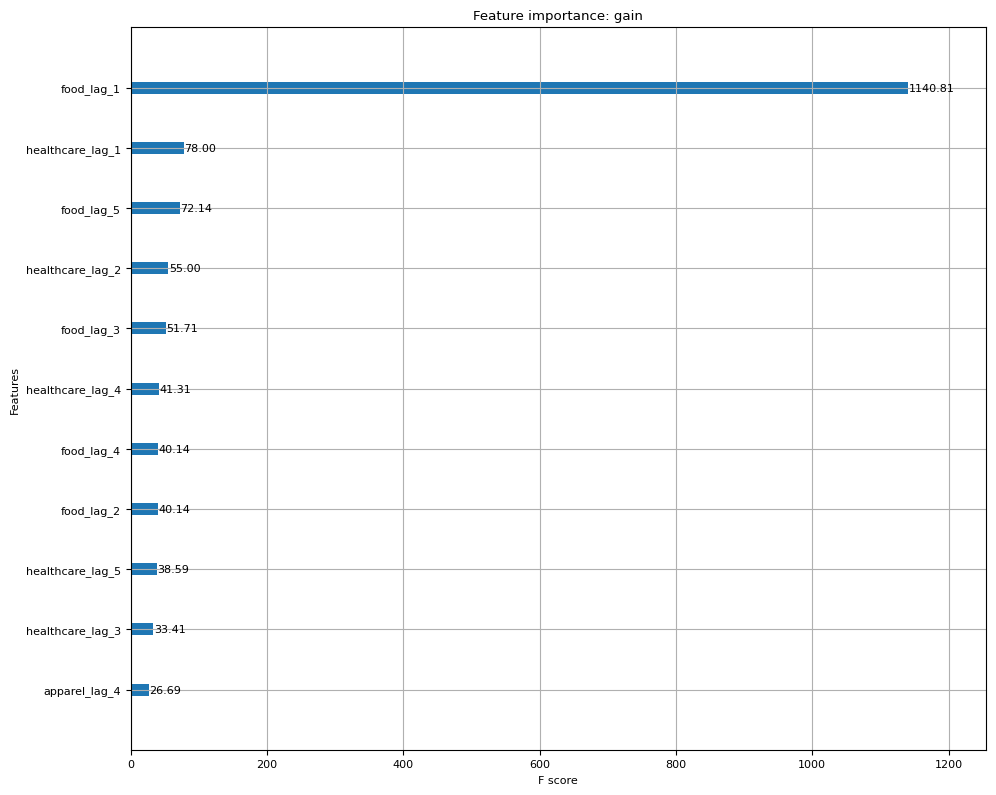

In [28]:
# =============================== Model XGBoost - trening ===============================================================================

best_params = study.best_params  # hiperparametry z Optuny

print('\n~~~~~~~~~~~~~~~~~~~~ Zbiór treningowy i testowy do XGBoost (final model) ~~~~~~~~~~~~~~~~~~~~')
X_train = X_final[-(TRAIN_SIZE + TEST_SIZE):-TEST_SIZE]  #najnowsze TRAIN_SIZE próbek przed testowymi
y_train = y[-(TRAIN_SIZE + TEST_SIZE):-TEST_SIZE]
X_test = X_final[-TEST_SIZE:]    #najnowsze próbki (TEST_SIZE)
y_test = y[-TEST_SIZE:]

print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

final_model = xgb.XGBRegressor(**best_params)
final_model.fit(X_train, y_train)

y_pred_train=final_model.predict(X_train)

train_rmse = np.sqrt(np.mean((y_pred_train - y_train) ** 2))
train_mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
print('\nRMSE modelu (trening):', round(train_rmse, 2))
print('MAPE modelu (trening):', round(train_mape, 2), '%')

# Prognoza i ocena
y_pred = final_model.predict(X_test)
final_rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))
final_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print('\nRMSE modelu (okres testowy):', round(final_rmse, 2))
print('MAPE modelu (okres testowy):', round(final_mape, 2), '%')

fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(final_model, importance_type='gain', ax=ax,values_format='{v:.2f}')
ax.set_title('Feature importance: gain')
plt.tight_layout()
plt.show()


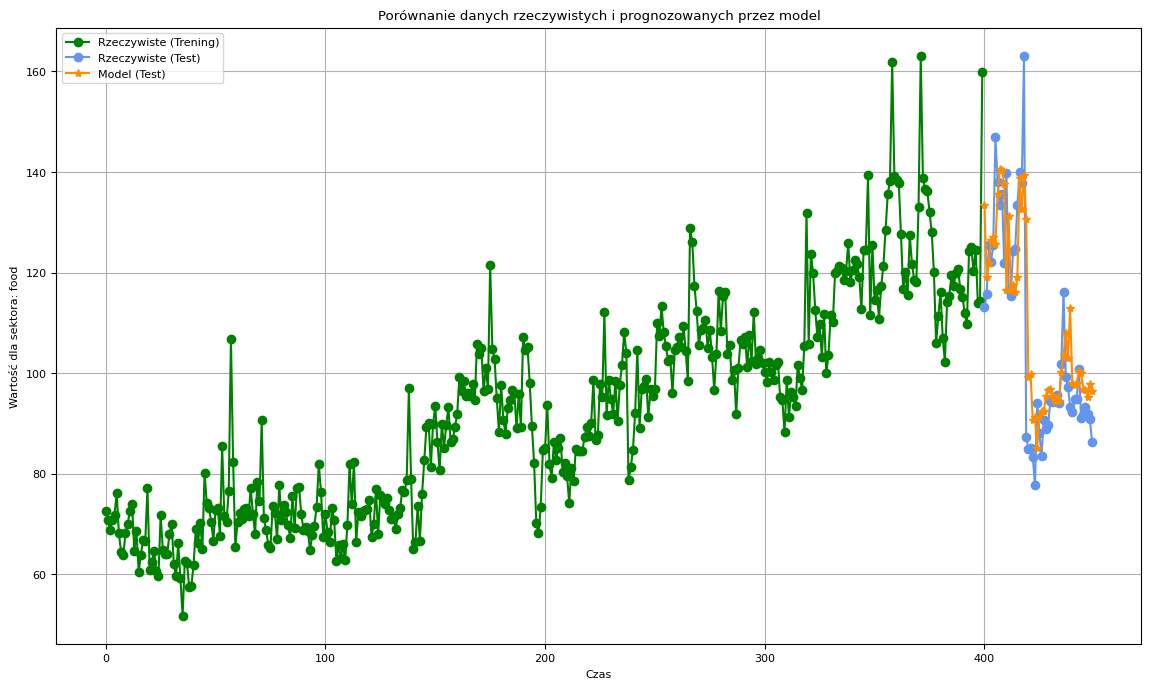

In [29]:
# ============================= Model XGBoost vs rzeczywiste WYKRES ========================================================================================
# Indeksy czasowe dla danych treningowych i testowych
train_steps = np.arange(len(y_train))                             # Indeksy dla treningu
test_steps = np.arange(len(y_train), len(y_train) + len(y_test))  # Indeksy dla testu (kontynuacja po treningu)

plt.figure(figsize=(14, 8))

# Rzeczywiste dane
plt.plot(train_steps, y_train, label='Rzeczywiste (Trening)', color='green', marker='o')
plt.plot(test_steps, y_test, label='Rzeczywiste (Test)', color='cornflowerblue', marker='o')

# Prognozy modelu na zbiorze testowym
plt.plot(test_steps, y_pred, label='Model (Test)', color='darkorange', marker='*')

# Dostosowanie wykresu
plt.title('Porównanie danych rzeczywistych i prognozowanych przez model')
plt.xlabel('Czas')
plt.ylabel(f'Wartość dla sektora: {sector_Y}')
plt.legend()
plt.grid(True)
plt.show()


========================== Shapley values ==========================
Wpływ poszczególnych zmiennych na predykcję:


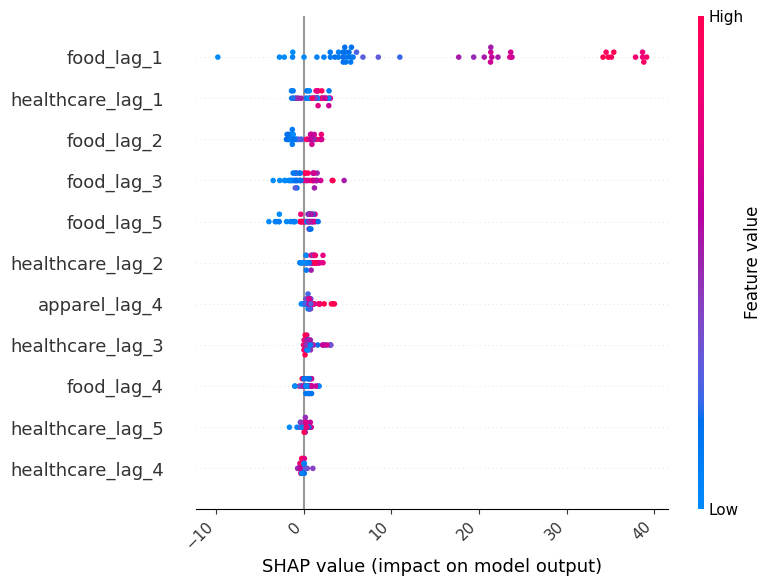

In [30]:
# ============================= Shapley values ====================================================================================================
print('========================== Shapley values ==========================')
print('Wpływ poszczególnych zmiennych na predykcję:')
explainer = shap.TreeExplainer(final_model)
shap_values = explainer(X_test)

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, show=False)    # Wpływ cech na przewidywaną wartość modelu
plt.xticks(rotation=45, ha='right')                   # Ustawienie kąta nachylenia etykiet osi
plt.tight_layout()                                    # Automatyczne dopasowanie marginesów
plt.show()



~~~~~~~~~~~~~~~~~~~~ PROGNOZA NA TYDZIEŃ: 2025-01-25 - 2025-01-31 ~~~~~~~~~~~~~~~~~~~~

Prognoza wartości indeksu:  [93.38849]
Wartość indeksu w obecnym tygodniu: 86.30160887816426

Rekomendacja dla sektora food: KUP 🟢


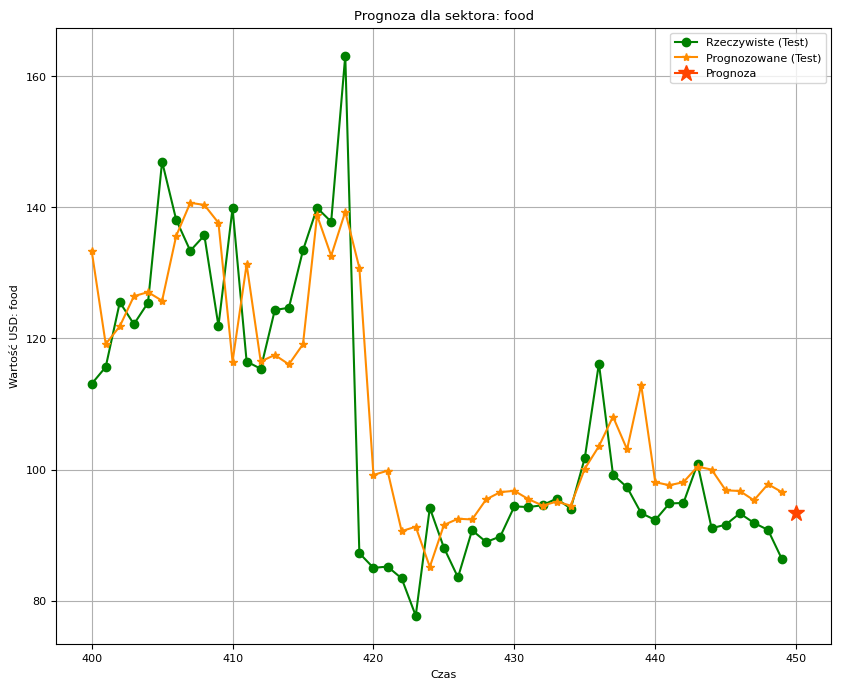


========================== Waterfall Plot ==========================


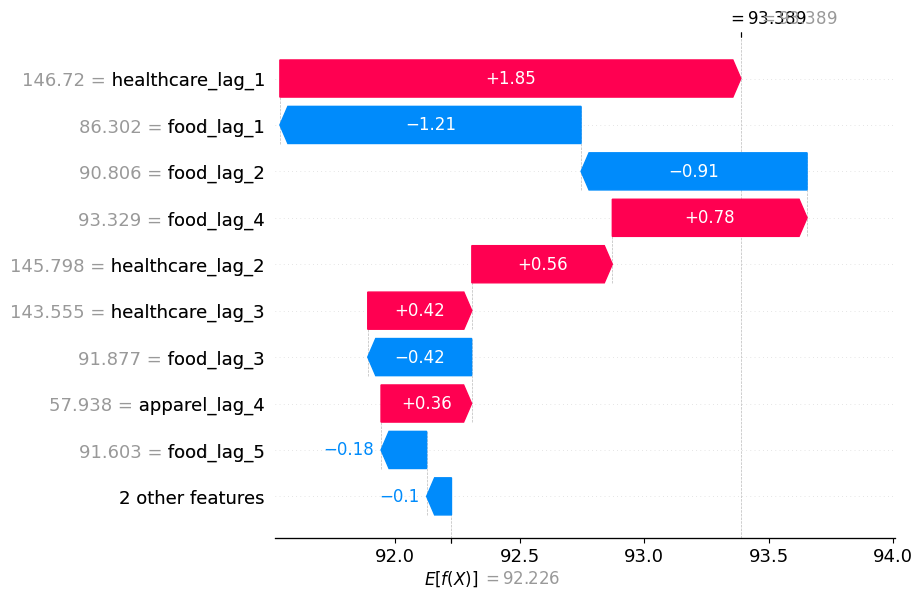


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ KONIEC ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [31]:
# ============================== PROGNOZA NA KOLEJNY TYDZIEŃ ================================================================================================
data_od = newest_date + timedelta(days=1)
data_do = data_od + timedelta(days=6)
print(f'\n~~~~~~~~~~~~~~~~~~~~ PROGNOZA NA TYDZIEŃ: {data_od} - {data_do} ~~~~~~~~~~~~~~~~~~~~')

# Tworzenie nowego wiersza
new_row = {}

for col in X_test.columns:
    lag_number = int(col[-1])  # Pobieranie numeru lag
    if lag_number == 1:
        # Wartości dla '_lag_1' pochodzą z danych pierwotnych (bez opóźnień)
        col_orginal = col.split('_')[0]
        new_row[col] = data_industry_weekly[col_orginal].iloc[-1]
    else:
        # Wartości dla '_lag_2', '_lag_3', itd. pochodzą  z kolumny o numerze lag-1 ze zbioru danych opóźnionych
        previous_col = col.replace(f'_lag_{lag_number}', f'_lag_{lag_number - 1}')
        new_row[col] = data_lagged[previous_col].iloc[-1]

new_row_df = pd.DataFrame([new_row])  # Do dataframe
y_pred_next = final_model.predict(new_row_df)
print('\nPrognoza wartości indeksu: ', y_pred_next)

y_pred_last = y_test.iloc[-1]
print('Wartość indeksu w obecnym tygodniu:', y_pred_last)
if y_pred_next > y_pred_last:
    print(f'\nRekomendacja dla sektora {sector_Y}: KUP \U0001F7E2')
else:
    print(f'\nRekomendacja dla sektora {sector_Y}: SPRZEDAJ \U0001F534')

# Wykres z prognozą na kolejny tydzień
test_steps = np.arange(len(y_train), len(y_train) + len(y_test))                      # Indeksy dla testu (kontynuacja po treningu)
progn_steps = np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 1)   # Indeks dla predykcji (kontynuacja po testowym)

plt.figure(figsize=(10, 8))
# Rzeczywiste dane
plt.plot(test_steps, y_test, label='Rzeczywiste (Test)', color='green', marker='o')
# Prognozy modelu na zbiorze testowym
plt.plot(test_steps, y_pred, label='Prognozowane (Test)', color='darkorange', marker='*')
# Prognoza kolejnego tygodnia
plt.plot(progn_steps, y_pred_next, label='Prognoza', color='orangered', marker='*', markersize=12)

# Dostosowanie wykresu
plt.title(f'Prognoza dla sektora: {sector_Y}')
plt.xlabel('Czas')
plt.ylabel(f'Wartość USD: {sector_Y}')
plt.legend()
plt.grid(True)
plt.show()

# Waterfall Plot (wpływ poszczególnych zmiennych na prognozę)
print('\n========================== Waterfall Plot ==========================')
explainer = shap.TreeExplainer(final_model)
shap_values = explainer(new_row_df)
shap.plots.waterfall(shap_values[-1])

print(f'\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ KONIEC ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')